<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Neural-Network/blob/main/06%20-%20Processing_Sequences_Using_Rnns_And_Cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# 기본 RNN
## 1.데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [5]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [6]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

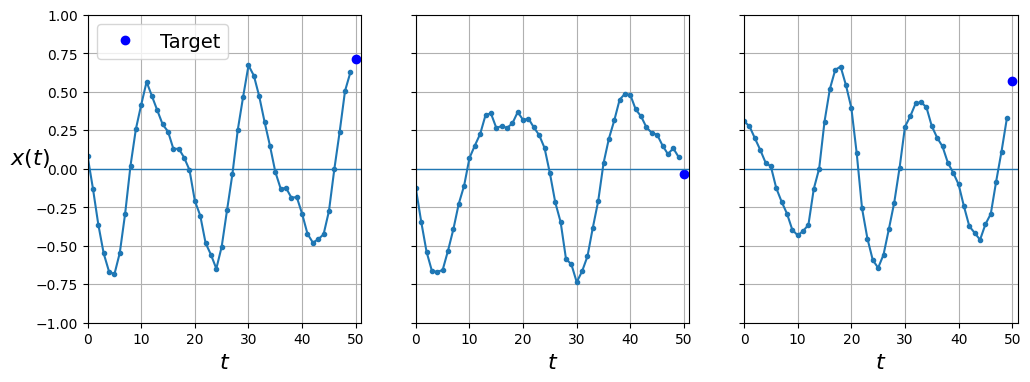

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col==0 else None), legend=(col == 0))
plt.show()

## 2.단순한 예측

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02123127

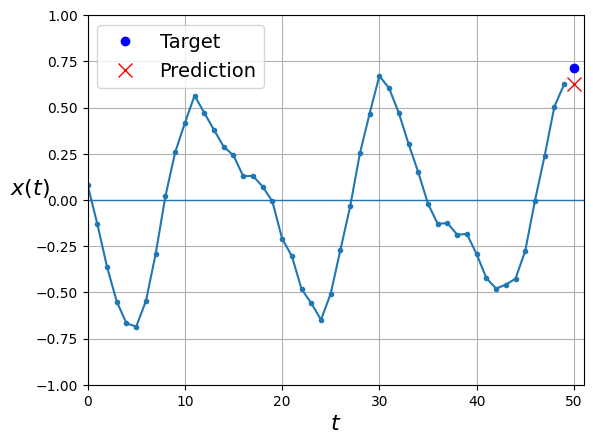

In [9]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 3.선형 예측

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.2970 - val_loss: 0.1179
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0790 - val_loss: 0.0508
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0403 - val_loss: 0.0316
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0231
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0211 - val_loss: 0.0185
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0150 - val_loss: 0.0136
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0131 - val_loss: 0.0120
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0097

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0045


0.004464608151465654

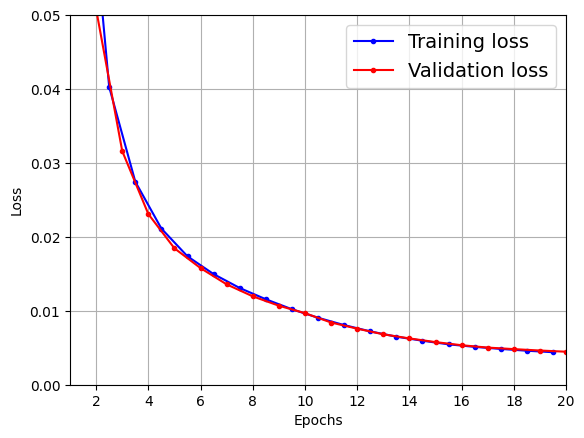

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# 간단한 RNN 사용

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 34ms/step - loss: 0.4778 - val_loss: 0.2584
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.1920 - val_loss: 0.1423
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.1473 - val_loss: 0.1387
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.1492 - val_loss: 0.1419
Epoch 5/20
219/219 [==============================] - 7s 33ms/step - loss: 0.1483 - val_loss: 0.1431
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1161 - val_loss: 0.0750
Epoch 7/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0560 - val_loss: 0.0449
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0378 - val_loss: 0.0339
Epoch 9/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0296 - val_loss: 0.0278
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0247 - val_lo

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0119


0.011858277022838593

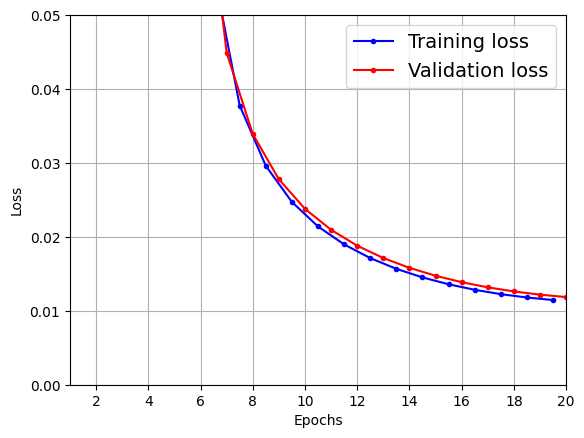

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


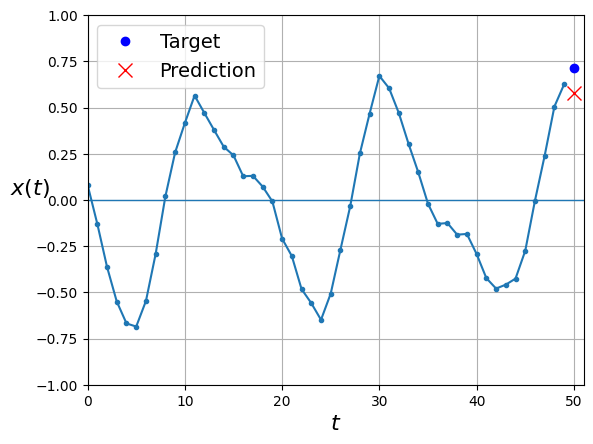

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 심층 RNN

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 30s 120ms/step - loss: 0.0131 - val_loss: 0.0047
Epoch 2/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 26s 119ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 26s 119ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 32s 144ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 26s 117ms/step - l

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0028


0.0028067221865057945

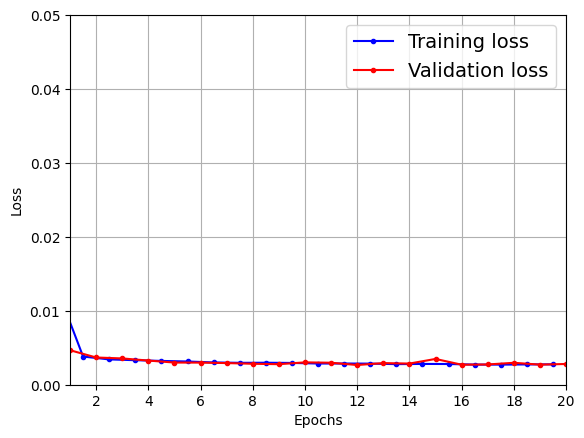

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 2s 19ms/step


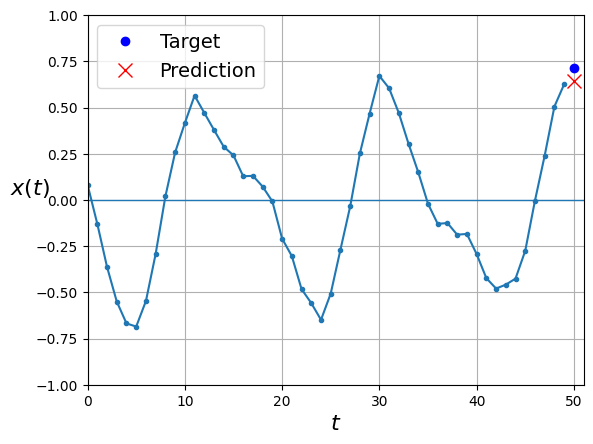

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 여러 타임 스텝 앞을 예측

In [21]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [22]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [23]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 78ms/step - loss: 0.0499 - last_time_step_mse: 0.0386 - val_loss: 0.0416 - val_last_time_step_mse: 0.0297
Epoch 2/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0388 - last_time_step_mse: 0.0257 - val_loss: 0.0401 - val_last_time_step_mse: 0.0271
Epoch 3/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0326 - last_time_step_mse: 0.0202 - val_loss: 0.0293 - val_last_time_step_mse: 0.0164
Epoch 4/20
219/219 [==============================] - 17s 75ms/step - loss: 0.0296 - last_time_step_mse: 0.0169 - val_loss: 0.0255 - val_last_time_step_mse: 0.0123
Epoch 5/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0260 - last_time_step_mse: 0.0129 - val_loss: 0.0237 - val_last_time_step_mse: 0.0106
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0234 - last_time_step_mse: 0.0105 - val_loss: 0.0249 - val_last_time_step_mse: 0.0142
Epoch 7/20
219/2

In [25]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 212ms/step


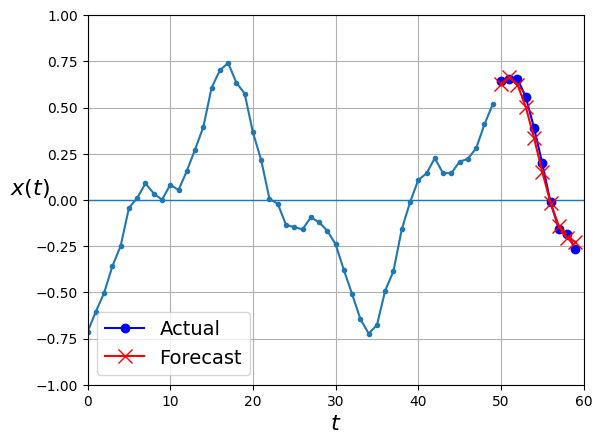

In [26]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 긴 시퀀스 다루기
## 1.배치 정규화를 사용한 심층 RNN

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 20s 78ms/step - loss: 0.1442 - last_time_step_mse: 0.1396 - val_loss: 0.1350 - val_last_time_step_mse: 0.1374
Epoch 2/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0542 - last_time_step_mse: 0.0439 - val_loss: 0.0574 - val_last_time_step_mse: 0.0472
Epoch 3/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0470 - last_time_step_mse: 0.0360 - val_loss: 0.0463 - val_last_time_step_mse: 0.0360
Epoch 4/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0426 - last_time_step_mse: 0.0314 - val_loss: 0.0405 - val_last_time_step_mse: 0.0292
Epoch 5/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0386 - last_time_step_mse: 0.0271 - val_loss: 0.0384 - val_last_time_step_mse: 0.0276
Epoch 6/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0357 - last_time_step_mse: 0.0239 - val_loss: 0.0353 - val_last_time_step_mse: 0.0232
Epoch 7/20
219/2

## 2.층 정규화를 사용한 심층 RNN

In [28]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 38s 160ms/step - loss: 0.1508 - last_time_step_mse: 0.1348 - val_loss: 0.0624 - val_last_time_step_mse: 0.0461
Epoch 2/20
219/219 [==============================] - 33s 152ms/step - loss: 0.0563 - last_time_step_mse: 0.0415 - val_loss: 0.0518 - val_last_time_step_mse: 0.0380
Epoch 3/20
219/219 [==============================] - 35s 159ms/step - loss: 0.0489 - last_time_step_mse: 0.0352 - val_loss: 0.0461 - val_last_time_step_mse: 0.0327
Epoch 4/20
219/219 [==============================] - 35s 159ms/step - loss: 0.0440 - last_time_step_mse: 0.0304 - val_loss: 0.0424 - val_last_time_step_mse: 0.0291
Epoch 5/20
219/219 [==============================] - 33s 151ms/step - loss: 0.0403 - last_time_step_mse: 0.0265 - val_loss: 0.0389 - val_last_time_step_mse: 0.0250
Epoch 6/20
219/219 [==============================] - 34s 158ms/step - loss: 0.0371 - last_time_step_mse: 0.0228 - val_loss: 0.0357 - val_last_time_step_mse: 0.0210
Epoch 7/20

## 3.사용자 정의 RNN 클래스

In [30]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, "get_initial_state", self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 45s 193ms/step - loss: 0.1117 - last_time_step_mse: 0.0989 - val_loss: 0.0654 - val_last_time_step_mse: 0.0562
Epoch 2/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0585 - last_time_step_mse: 0.0475 - val_loss: 0.0526 - val_last_time_step_mse: 0.0401
Epoch 3/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0517 - last_time_step_mse: 0.0392 - val_loss: 0.0475 - val_last_time_step_mse: 0.0345
Epoch 4/20
219/219 [==============================] - 41s 188ms/step - loss: 0.0457 - last_time_step_mse: 0.0325 - val_loss: 0.0441 - val_last_time_step_mse: 0.0317
Epoch 5/20
219/219 [==============================] - 38s 175ms/step - loss: 0.0424 - last_time_step_mse: 0.0289 - val_loss: 0.0408 - val_last_time_step_mse: 0.0278
Epoch 6/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0400 - last_time_step_mse: 0.0264 - val_loss: 0.0382 - val_last_time_step_mse: 0.0249
Epoch 7/20

## 4.LSTM

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 12ms/step - loss: 0.0755 - last_time_step_mse: 0.0613 - val_loss: 0.0530 - val_last_time_step_mse: 0.0323
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0465 - last_time_step_mse: 0.0259 - val_loss: 0.0422 - val_last_time_step_mse: 0.0221
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0381 - last_time_step_mse: 0.0173 - val_loss: 0.0360 - val_last_time_step_mse: 0.0151
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0343 - last_time_step_mse: 0.0142 - val_loss: 0.0330 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0323 - last_time_step_mse: 0.0132 - val_loss: 0.0315 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0308 - last_time_step_mse: 0.0123 - val_loss: 0.0300 - val_last_time_step_mse: 0.0118
Epoch 7/20
219/219 [=====

## 5.GRU

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 13ms/step - loss: 0.0728 - last_time_step_mse: 0.0639 - val_loss: 0.0536 - val_last_time_step_mse: 0.0424
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0480 - last_time_step_mse: 0.0372 - val_loss: 0.0443 - val_last_time_step_mse: 0.0333
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0430 - last_time_step_mse: 0.0315 - val_loss: 0.0410 - val_last_time_step_mse: 0.0292
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0398 - last_time_step_mse: 0.0284 - val_loss: 0.0370 - val_last_time_step_mse: 0.0252
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0346 - last_time_step_mse: 0.0215 - val_loss: 0.0330 - val_last_time_step_mse: 0.0187
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0311 - last_time_step_mse: 0.0167 - val_loss: 0.0299 - val_last_time_step_mse: 0.0146
Epoch 7/20
219/219 [======

## 6.1D 합성곱 층을 사용한 시퀀스 처리

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 7s 11ms/step - loss: 0.0676 - last_time_step_mse: 0.0600 - val_loss: 0.0440 - val_last_time_step_mse: 0.0352
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0390 - last_time_step_mse: 0.0314 - val_loss: 0.0337 - val_last_time_step_mse: 0.0253
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0312 - last_time_step_mse: 0.0224 - val_loss: 0.0290 - val_last_time_step_mse: 0.0194
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0271 - last_time_step_mse: 0.0168 - val_loss: 0.0255 - val_last_time_step_mse: 0.0150
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0246 - last_time_step_mse: 0.0136 - val_loss: 0.0241 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0233 - last_time_step_mse: 0.0120 - val_loss: 0.0226 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [======

## 7.WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 11ms/step - loss: 0.0642 - last_time_step_mse: 0.0527 - val_loss: 0.0343 - val_last_time_step_mse: 0.0214
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0313 - last_time_step_mse: 0.0188 - val_loss: 0.0290 - val_last_time_step_mse: 0.0169
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0280 - last_time_step_mse: 0.0160 - val_loss: 0.0277 - val_last_time_step_mse: 0.0167
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0264 - last_time_step_mse: 0.0144 - val_loss: 0.0257 - val_last_time_step_mse: 0.0142
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0251 - last_time_step_mse: 0.0133 - val_loss: 0.0245 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0240 - last_time_step_mse: 0.0121 - val_loss: 0.0234 - val_last_time_step_mse: 0.0113
Epoch 7/20
219/219 [=======